In [2]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import torch.nn.functional as F
import gym_minigrid
import numpy as np
import matplotlib.pyplot as plt
import gym
from tqdm.notebook import tqdm
from gym_minigrid.envs.doorkey import DoorKeyEnv
import pandas as pd
import random
from tqdm import tqdm
from typing_extensions import Self
import matplotlib.pyplot as plt

/Users/atticusw/opt/anaconda3/lib/python3.9/site-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Config:
    """
    Stores algorithmic hyperparameters.
    """
    def __init__(self,
                score_threshold=0.93,
                discount=0.995,
                lr=1e-3,
                max_grad_norm=0.5,
                log_interval=10,
                max_episodes=2000,
                gae_lambda=0.95,
                use_critic=True,
                clip_ratio=0.2,
                target_kl=0.01,
                train_ac_iters=5,
                use_discounted_reward=False,
                entropy_coef=0.01,
                use_gae=True,
                my_var=0):

        self.score_threshold = score_threshold # criterion for early stopping. If the rolling average reward (over the last 100 episodes) is greater than it, it ends.
        self.discount = discount # discount factor
        self.lr = lr # learning rate
        self.max_grad_norm = max_grad_norm # the maximum gradient norm (https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html)
        self.log_interval = log_interval # logging interval
        self.max_episodes = max_episodes # the maximum number of episodes.
        self.use_critic = use_critic # whether to use critic or not.
        self.clip_ratio = clip_ratio # clip_ratio of PPO.
        self.target_kl = target_kl # target KL divergence for early stoping train_ac_iters for PPO
        self.train_ac_iters = train_ac_iters # how many time to train ac_model using current computed old_logps
        self.gae_lambda=gae_lambda # lambda in Generalized Advantage Estimation (GAE)
        self.use_discounted_reward=use_discounted_reward # whether use discounted reward or not.
        self.entropy_coef = entropy_coef # entropy coefficient for PPO
        self.use_gae = use_gae # whether to use GAE or not.
        self.my_var = my_var # a variable for testing purposes.

In [4]:
# Function from https://github.com/ikostrikov/pytorch-a2c-ppo-acktr/blob/master/model.py
def init_params(m):
    """
    Initialize parameters of the network.
    m: torch.nn.Module
    """
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        m.weight.data.normal_(0, 1)
        m.weight.data *= 1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)

def preprocess_obss(obss, device=None):
    """
    Convert observation into Torch.Tensor

    Parameters
    ----
    obss: dictionary or np.ndarray
    device: target device of torch.Tensor ('cpu', 'cuda')

    Return
    ----
    Torch Tensor
    """
    if isinstance(obss, dict):
        images = np.array([obss["image"]])
    else:
        images = np.array([o["image"] for o in obss])

    return torch.tensor(images, device=device, dtype=torch.float)

class DoorKeyEnv5x5(DoorKeyEnv):
    def __init__(self):
        self.render_mode = "rgb_array"
        super().__init__(size=5)

    def _reward(self):
        """
        Compute the reward to be given upon success
        """
        return 1
    
class DoorKeyEnv6x6(DoorKeyEnv):
    def __init__(self):
        self.render_mode = "rgb_array"
        super().__init__(size=6)

    def _reward(self):
        """
        Compute the reward to be given upon success
        """
        return 1
    
class DoorKeyEnv8x8(DoorKeyEnv):
    def __init__(self):
        self.render_mode = "rgb_array"
        super().__init__(size=8)

    def _reward(self):
        """
        Compute the reward to be given upon success
        """
        return 1

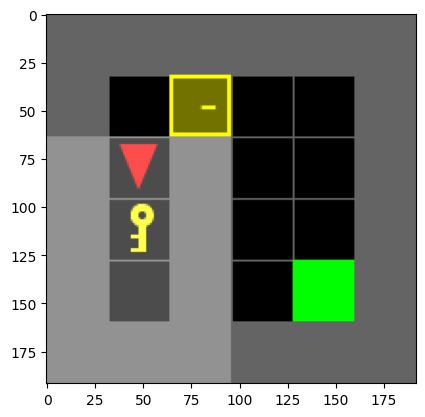

In [5]:
env = DoorKeyEnv6x6() # define environment.
env.reset()
action = env.action_space.sample()
obs, reward, terminated, truncated, info = env.step(action)

# get an RGB image corresponding to the whole environment or the agent's point of view (https://github.com/Farama-Foundation/Minigrid/blob/master/minigrid/minigrid_env.py#L716)
#            highlight (bool): If true, the agent's field of view or point of view is highlighted with a lighter gray color.
#            tile_size (int): How many pixels will form a tile from the NxM grid.
#            agent_pov (bool): If true, the rendered frame will only contain the point of view of the agent.
frame = env.get_frame(highlight=env.highlight, tile_size=env.tile_size, agent_pov=env.agent_pov)
# show an image to the notebook.
plt.imshow(frame)

In [6]:
class ACModel(nn.Module):
    def __init__(self, num_actions, use_critic=True):
        """
        Represents an Actor Crictic model that takes a 2d, multi-channeled
        image as input.

        Parameters
        ----
        num_actions : int

                      The action space of the environment.
                      The action space for DoorKey5x5 is 7-dimensional:
                      0: turn left,
                      1: turn right,
                      2: forward,
                      3: pickup an object,
                      4: drop an object,
                      5: activate an object,
                      6: done completing task

        use_critics : bool

                      Critic network will be used in forward pass if flag is set
                      to true.
        """
        super().__init__()
        self.use_critic = use_critic

        # Define actor's model
        self.image_conv_actor = nn.Sequential(
            nn.Conv2d(3, 16, (2, 2)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU()
        )
        self.actor = nn.Sequential(
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, num_actions)
        )

        # Define critic's model
        if self.use_critic:
            self.image_conv_critic = nn.Sequential(
                nn.Conv2d(3, 16, (2, 2)),
                nn.ReLU(),
                nn.MaxPool2d((2, 2)),
                nn.Conv2d(16, 32, (2, 2)),
                nn.ReLU(),
                nn.Conv2d(32, 64, (2, 2)),
                nn.ReLU()
            )
            self.critic = nn.Sequential(
                nn.Linear(64, 64),
                nn.Tanh(),
                nn.Linear(64, 1)
            )

        # Initialize parameters correctly
        self.apply(init_params)

    def forward(self, obs):
        """
        Performs a forward pass through the actor-critic network

        Parameters
        ----
        obs : int tensor. Shape [Batch size, ImWidth, ImHeight, Channels]

              input to the network.
        ----

        returns:

        dist : torch.distribution
            The distribution of actions from policy. A Categorical distribution
            for discreet action spaces.
        value : torch.Tensor (Batch size, 1)
            value output by critic network
        """
        conv_in = obs.transpose(1, 3).transpose(2, 3) # reshape into [b, c, h, w]

        dist, value = None, None

        x = self.image_conv_actor(conv_in)
        embedding = x.reshape(x.shape[0], -1)

        x = self.actor(embedding)
        dist = Categorical(logits=F.log_softmax(x, dim=1))

        if self.use_critic:
            y = self.image_conv_critic(conv_in)
            embedding = y.reshape(y.shape[0], -1)

            value = self.critic(embedding).squeeze(1)
        else:
            value = torch.zeros((x.shape[0], 1), device=x.device)
        
        return dist, value

def compute_discounted_return(rewards, discount, device=DEVICE):
    """
		rewards: reward obtained at timestep.  Shape: (T,)
		discount: discount factor. float

    ----
    returns: sum of discounted rewards. Shape: (T,)
		"""
    returns = torch.zeros(*rewards.shape, device=device)

    R = 0
    for t in reversed(range((rewards.shape[0]))):
        R = rewards[t] + discount * R
        returns[t] = R
    return returns

def compute_advantage_gae(values, rewards, T, gae_lambda, discount):
    """
    Compute Adavantage with GAE. See Section 4.4.2 in the lecture notes.

    values: value at each timestep (T,)
    rewards: reward obtained at each timestep.  Shape: (T,)
    T: the number of frames, float
    gae_lambda: hyperparameter, float
    discount: discount factor, float

    -----

    returns:

    advantages : tensor.float. Shape [T,]

                 gae advantage term for timesteps 0 to T

    """
    advantages = torch.zeros_like(values)
    for i in reversed(range(T)):
        next_value = values[i+1]
        next_advantage = advantages[i+1]

        delta = rewards[i] + discount * next_value  - values[i]
        advantages[i] = delta + discount * gae_lambda * next_advantage
    return advantages[:T]

In [7]:
### TESTS

model = ACModel(num_actions=7, use_critic=True).to(DEVICE)
obss = env.reset()
obs = preprocess_obss(obss[0], DEVICE)
model(obs)

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


(Categorical(logits: torch.Size([1, 7])),
 tensor([-0.2645], grad_fn=<SqueezeBackward1>))

In [155]:
class Machine:
    def __init__(self, num_actions=7, args=Config()):
        """
        A Machine object consists of a ACModel, its hyperparameters, and its history of rewards.

        Args:
            num_actions: size of action space
            args: Model hyperparameters
        """
        self.args = args
        self.model = ACModel(num_actions, use_critic=True).to(DEVICE)
        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.args.lr)
        self.rewards = []

    def reset_rs(self) -> None:
        self.rewards = []

    def copy_machine(self, other: Self) -> None:
        """
        Copy state dict from 'other'. Reset rs.
        """
        state_dict = other.model.state_dict()
        for key, v in state_dict.items():
            self.model.state_dict()[key].copy_(v)
        
        self.reset_rs()

    def add_r(self, r: float) -> None:
        self.rewards.append(r)

    def avg_r(self) -> float:
        assert len(self.rewards) > 0, 'No rewards yet'
        return sum(self.rewards) / len(self.rewards)
    
    def collect_experiences(self, env:gym.Env):
        """
        Collects rollouts and computes advantages.

        Returns
        -------
        exps : dict
            Contains actions, rewards, advantages etc as attributes.
            Each attribute, e.g. `exps['reward']` has a shape
            (self.num_frames, ...).
        logs : dict
            Useful stats about the training process, including the average
            reward, policy loss, value loss, etc.
        """
        acmodel = self.model

        MAX_FRAMES_PER_EP = 300
        shape = (MAX_FRAMES_PER_EP, )

        actions = torch.zeros(*shape, device=DEVICE, dtype=torch.int)
        values = torch.zeros(*shape, device=DEVICE)
        rewards = torch.zeros(*shape, device=DEVICE)
        log_probs = torch.zeros(*shape, device=DEVICE)
        obss = [None]*MAX_FRAMES_PER_EP

        obs, _ = env.reset()

        total_return = 0

        T = 0

        while True:
            # Do one agent-environment interaction

            preprocessed_obs = preprocess_obss(obs, device=device)

            with torch.no_grad():
                dist, value = acmodel(preprocessed_obs)

            dist: Categorical
            action = dist.sample()[0]

            obss[T] = obs
            obs, reward, done, _, _ = env.step(action.item())


            # Update experiences values
            actions[T] = action
            values[T] = value
            rewards[T] = reward
            log_probs[T] = dist.log_prob(action)


            total_return += reward
            T += 1

            if done or T>=MAX_FRAMES_PER_EP-1:
                break

        discounted_reward = compute_discounted_return(rewards[:T], self.args.discount, device)
        exps = dict(
            obs = preprocess_obss([
                obss[i]
                for i in range(T)
            ], device=DEVICE),
            action = actions[:T],
            value  = values[:T],
            reward = rewards[:T],
            log_prob = log_probs[:T],
            discounted_reward = discounted_reward,
            label = self.label,
            T = T
        )

        logs = {
            "return_per_episode": total_return,
            "num_frames": T
        }

        return exps, logs

    def _compute_policy_loss_ppo(self, obs, init_logp, old_logp, actions, advantages):
        """
        Computes the policy loss for PPO.

        obs: observeration to pass into acmodel. shape: (T,)
        init_logp: log probabilities we get from the agent performing the action. shape: (T,)
        old_logp: log probabilities from previous timestep. shape: (T,)
        actions: action at this timestep. shape: (T,ImWidth,ImHeight,Channels)
        advantages: the computed advantages. shape: (T,)

        ---
        returns

        policy_loss : ppo policy loss as shown in line 6 of PPO alg. tensor.float. Shape (,1)
        approx_kl: an appoximation of the kl_divergence. tensor.float. Shape (,1)
        """
        policy_loss, approx_kl = 0, 0

        dist, _ = self.model(obs)
        dist: Categorical

        coef = self.coef

        entropy = dist.entropy()
        logps = dist.log_prob(actions)
        r_terms = torch.exp(logps - old_logp)
        ppo_loss = torch.min(r_terms * advantages, torch.clamp(r_terms, 1 - self.args.clip_ratio, 1 + self.args.clip_ratio) * advantages)
        
        # Importance sampling factor
        factors = torch.exp(old_logp - init_logp)
        
        indices = factors < 100
        policy_loss_tensor = factors * ppo_loss + coef * entropy

        policy_loss = - torch.mean(policy_loss_tensor[indices])

        # approx_kl = torch.sum(torch.exp(old_logp) * (old_logp - logps)) / torch.sum(torch.exp(old_logp))
        approx_kl = torch.mean((old_logp - logps) ** 2) / 2

        return policy_loss, approx_kl
    
    def _compute_value_loss(self, obs, returns):
        _, value = self.model(obs)

        value_loss = torch.mean((value - returns) ** 2)

        return value_loss


    def update_parameters(self, sb):
        
        MAX_FRAMES_PER_EP = 300
        T = sb['T']
        dist, values = self.model(sb['obs'])
        values = values.reshape(-1)
        dist: Categorical
        old_logp = dist.log_prob(sb['action']).detach()
        init_logp = sb['log_prob']

        # add 0 to end of values until it has length MAX_FRAMES_PER_EP
        values_extended = torch.cat([values, torch.zeros((MAX_FRAMES_PER_EP - len(values), ), device=DEVICE)], dim=0)
        full_reward = torch.cat([sb['reward'], torch.zeros((MAX_FRAMES_PER_EP - len(sb['reward']), ), device=DEVICE)], dim=0)

        if self.args.use_gae:
            advantage = compute_advantage_gae(values_extended, full_reward, T, self.args.gae_lambda, self.args.discount)
        else:
            advantage = sb['discounted_reward'] - values.reshape(-1)

        policy_loss, _ = self._compute_policy_loss_ppo(sb['obs'], init_logp, old_logp, sb['action'], advantage)
        value_loss = self._compute_value_loss(sb['obs'], sb['discounted_reward'])

        for i in range(self.args.train_ac_iters):
            self.optim.zero_grad()
            loss_pi, approx_kl = self._compute_policy_loss_ppo(sb['obs'], init_logp, old_logp, sb['action'], advantage)
            if sb['label'] == self.label:
                loss_v = self._compute_value_loss(sb['obs'], sb['discounted_reward'])
            else:
                loss_v = 0.0

            loss = loss_v + loss_pi
            if approx_kl > 1.5 * self.args.target_kl:
                break

            loss.backward(retain_graph=True)
            self.optim.step()

        update_policy_loss = policy_loss.item()
        update_value_loss = value_loss.item()

        logs = {
            "policy_loss": update_policy_loss,
            "value_loss": update_value_loss,
        }

        return logs

In [9]:
class MachineCluster:
    def __init__(self, hps:list[str], num_machines:int=5, num_survivors:int=2, num_trajs:int=40):
        """
        The cluster of machines.

        hps: A list of hyperparameters to optimize. Must be a subset of keys in Machine.args.
        num_machines: The number of machines in the cluster.
        num_survivors: The number of survivors to select from the cluster.
        num_trajs: The number of trajectories collected by each machine in each training epoch.
        """
        self.num_machines = num_machines
        self.num_survivors = num_survivors
        self.hps = hps
        self.num_trajs = num_trajs
        self.machines = []
        for _ in range(self.num_machines):
            self.models.append(Machine())

        # now let's say hps = ['entropy_coef']
        for hp in hps:
            # sample num_models values from a uniform distribution
            values = np.random.uniform(0, 1, size=num_machines)
            # set the hyperparameters of the models
            self.update_hp(hp, values)

    def generate_data(self):
        """
        Generate batches of data for training the models.

        Return:
            trajs: list of exps.  
        """

        trajs = []

        for i, _ in range(self.num_machines), range(self.num_trajs):
            exps, _ = self.machines[i].collect_experiences(env)
            trajs.append(exps)
        
        print(f'Finished generating {len(trajs)} trajectories')
        return trajs

    def train(self, data):
        """
        Train the models in the cluster.

        Args:
            data: list of exps.
        """

        MAX_FRAMES_PER_EP = 300
        
        for machine in self.machines:

            total_policy_loss = 0
            total_value_loss = 0

            for sb in data:
                T = sb['T']
                obs = sb['obs']
                dist, values = machine(obs)
                init_logp = sb['log_prob']
                old_logp = dist.log_prob(sb['action']).detach()

                # add 0 to end of values until it has length MAX_FRAMES_PER_EP
                values_extended = torch.cat([values, torch.zeros((MAX_FRAMES_PER_EP - len(values), ), device=DEVICE)], dim=0)
                full_reward = torch.cat([sb['reward'], torch.zeros((MAX_FRAMES_PER_EP - len(sb['reward']), ), device=DEVICE)], dim=0)
                assert len(values_extended) == MAX_FRAMES_PER_EP
                assert len(full_reward) == MAX_FRAMES_PER_EP
                
                # compute advantage
                if machine.args.use_gae:
                    advantage = compute_advantage_gae(values_extended, full_reward, T, machine.args.gae_lambda, machine.args.discount)
                else:
                    advantage = sb['discounted_reward'] - values.reshape(-1)
                
                # compute policy and value loss
                policy_loss, _ = machine._compute_policy_loss_ppo(obs, init_logp, old_logp, sb['action'], advantage)

                value_loss = machine._compute_value_loss(obs, sb['discounted_reward'])

                total_policy_loss += policy_loss
                total_value_loss += value_loss
            
            machine.optim.zero_grad()


            loss = total_policy_loss + total_value_loss

            loss.backward()
            machine.optim.step()
        
    def evaluate(self, trained_models):
        """
        Evaluate the performance of the models in the cluster.

        Args:
        - trained_models: list of ExtendedModels.

        Returns:
        - performances:
        """

        return performances


    def update_hp(self, hp:str, targets:list[float]) -> None:
        """
        Update the hyperparameters of the models in the cluster.

        Args:
            hp: The hyperparameter to update.
            targets: The target hyperparameter values.
                    Has length self.num_models.
        """
        for i, target in enumerate(targets):
            self.models[i].update_arg(hp, target)

    def eliminate(self, trained_models, performances):
        """
        The elimination process to select the survivors.
        Also shift hyperparams.
        """

        return elites
    
    def reproduce(self):
        """
        Reproduce models.
        """

        return NotImplementedError

SyntaxError: invalid syntax (1887660741.py, line 57)

In [ ]:
def run_cluster_experiment(hps:list[str], num_models:int=5, num_survivors:int=2, num_trajs:int=40, num_epochs:int=10, seed=42):
    """
    Run the cluster experiment.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    cluster = MachineCluster(hps = hps, num_models = num_models, num_survivors = num_survivors, num_trajs = num_trajs)

    pbar = tqdm(range(num_epochs))
    logs = dict(
        rewards = [],
        smooth_rewards = []
    )
    pdlogs = []

    for epoch in pbar:
        # Generate data
        obs = cluster.generate_data()

        # Train until data fits poorly
        cluster.train(data=obs)
        trained_models = cluster.models

        # Evaluate performances
        performances = cluster.evaluate(trained_models)
        logs.append(performances) # what is in logs?

        # Survival of the fittest
        survivors = cluster.eliminate(trained_models, performances)
        cluster.reproduce(survivors)

    return pd.DataFrame(pdlogs).set_index('epoch')

In [ ]:
df = run_cluster_experiment(hps=['entropy_coef'])

# df.plot(x='num_frames', y=['reward', 'smooth_reward'])

In [157]:
def run_experiment(coefs:list[float], max_steps:int, env=DoorKeyEnv6x6(), args=Config(), seed=0):
    """
    Upper level function for running experiments to analyze reinforce and
    policy gradient methods. Instantiates a model, collects epxeriences, and
    then updates the neccessary parameters.

    Args:
        coefs: a list of coefs each machine has
        max_steps: maximum number of steps to run the experiment for.
        env: the environment to use. 
        args: Config object with hyperparameters.
        seed: random seed. int

    Returns:
        DataFrame indexed by episode
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    device = DEVICE

    machines = [Machine(coef, label=idx, args=args) for idx, coef in enumerate(coefs)]
    winners = []
    full_rs = []

    is_solved = False

    SMOOTH_REWARD_WINDOW = 50

    pd_logs, rewards = [], [0]*SMOOTH_REWARD_WINDOW

    num_frames = 0

    pbar = tqdm(range(max_steps))
    for update in pbar:

        label = update % len(machines)

        machine = machines[label]
        
        exps, logs1 = machine.collect_experiences(env)

        for m in machines:
            if m is machine:
                logs2 = m.update_parameters(exps)
            else:
                m.update_parameters(exps)

        logs = {**logs1, **logs2}

        num_frames += logs["num_frames"]

        rewards.append(logs["return_per_episode"])

        smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])

        data = {'episode':update, 'num_frames':num_frames, 'smooth_reward':smooth_reward,
               'reward':logs["return_per_episode"], 'policy_loss':logs["policy_loss"]}

        if args.use_critic:
            data['value_loss'] = logs["value_loss"]

        pd_logs.append(data)

        pbar.set_postfix(data)

        machine.add_r(rewards[-1])
        if update % (20 * len(machines)) == 0 and update > 0:
            full_rs.append([m.avg_r() for m in machines])
            winner = survival_fittest(machines)
            winners.append(winner)

        # # Early terminate
        # if smooth_reward >= args.score_threshold:
        #     is_solved = True
        #     break

    if is_solved:
        print('Solved!')

    for m in machines:
        print(m.avg_r())
    print(winners)
    print(full_rs)

    return pd.DataFrame(pd_logs).set_index('episode')
